<a href="https://colab.research.google.com/github/YueunKim/Kriss_DL/blob/master/unet_segementation_color_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 컬러 영상 영역분할

공개SW협회의 주관의 Open Up의 인공지능“이미지의 사물 검출에 딥러닝 활용(심화)”전문교육 프로그램중의 교재를 가져와서 수정함

https://edu.kosslab.kr/course/view.php?id=34


In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import cv2

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model

Using TensorFlow backend.


# 데이터 준비

## 데이터 다운로드

http://www.robots.ox.ac.uk/~vgg/data/pets/ 의 데이터를 사용.

In [3]:
%%shell
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2020-12-22 01:06:28--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2020-12-22 01:06:28--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  34.9MB/s    in 22s     

2020-12-22 01:06:51 (34.1 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2020-12-22 01:06:51--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

## 압축 풀기

In [4]:
%%shell
tar -xvzf images.tar.gz
tar -xvzf annotations.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

## 불필요한 파일 삭제

In [5]:
!rm images/*.mat
!rm annotations/trimaps/._*

## 풀린 데이터 파일 구조

```
images/
  Abyssinian_1.jpg
  Abyssinian_10.jpg
  Abyssinian_100.jpg
  ...
annotations/
  trimaps/
    Abyssinian_1.png
    Abyssinian_10.png
    Abyssinian_100.png
    ...
  xmls/            # 사용한함.  PASCAL VOC Format의 object dtection 레이블
    Abyssinian_1.xml
    Abyssinian_10.xml
    Abyssinian_100.xml
    ...
  README           # 사용 안한
  list.txt         # 사용 안함
  test.txt         # 사용 안함
  trainval.txt     # 사용 안함
```

In [6]:
%%shell
ls -al images/ | head
ls -al annotations/trimaps/ | head

total 789120
drwxr-xr-x 2 1001 1001  311296 Dec 22 01:07 .
drwxr-xr-x 1 root root    4096 Dec 22 01:07 ..
-rwxr-xr-x 1 1001 1001  126923 Jun 18  2012 Abyssinian_100.jpg
-rwxr-xr-x 1 1001 1001   49023 Jun 18  2012 Abyssinian_101.jpg
-rwxr-xr-x 1 1001 1001  165505 Jun 18  2012 Abyssinian_102.jpg
-rwxr-xr-x 1 1001 1001  132937 Jun 18  2012 Abyssinian_103.jpg
-rwxr-xr-x 1 1001 1001   34907 Jun 18  2012 Abyssinian_104.jpg
-rwxr-xr-x 1 1001 1001  141823 Jun 18  2012 Abyssinian_105.jpg
-rwxr-xr-x 1 1001 1001  197092 Jun 18  2012 Abyssinian_106.jpg
total 31104
drwxr-xr-x 2 501 staff 602112 Dec 22 01:07 .
drwxr-xr-x 4 501 staff   4096 Jun 30  2012 ..
-rwxr-xr-x 1 501 staff   3555 Jun 18  2012 Abyssinian_100.png
-rwxr-xr-x 1 501 staff   2468 Jun 18  2012 Abyssinian_101.png
-rwxr-xr-x 1 501 staff   3554 Jun 18  2012 Abyssinian_102.png
-rwxr-xr-x 1 501 staff   2791 Jun 18  2012 Abyssinian_103.png
-rwxr-xr-x 1 501 staff   3602 Jun 18  2012 Abyssinian_104.png
-rwxr-xr-x 1 501 staff   2521 Jun 18  20

## 파일 보기

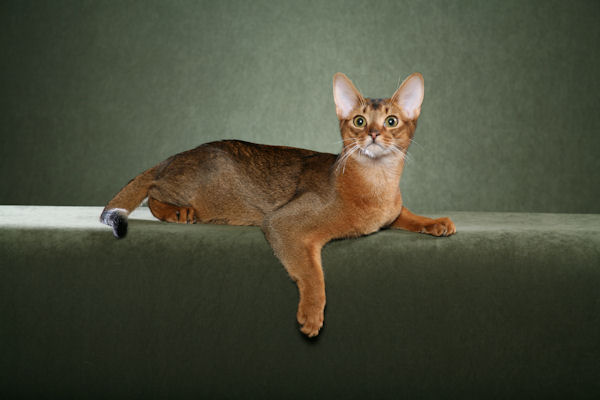

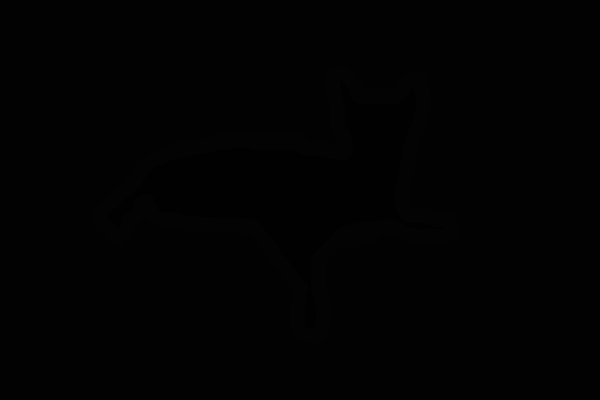

In [7]:
from IPython.display import Image, display

display(Image('images/Abyssinian_1.jpg'))
display(Image('annotations/trimaps/Abyssinian_1.png'))


annoation 파일은 일반 이미지 파일이 아니고, 각 픽셀별 category 값이 담긴 파일이다.
그냥 봐서는 보이지 않는다.

(400, 600)


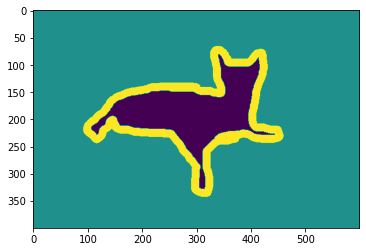

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3]


In [8]:
label = cv2.imread('annotations/trimaps/Abyssinian_1.png', cv2.IMREAD_GRAYSCALE)
print(label.shape)
plt.imshow(label)
plt.show()
print(label[100][300:360])

category 값은 README 파일에 명시되어 있다.
- 1: 전경
- 2: 배경
- 3: 이외

# ImageDataGenerator 선언

keras의 ImageDataGenerator를 사용하여 파일을 읽는다.

파일의 크기가 제각각이라 256x256 사이즈로 로딩한다.


In [9]:
from keras.preprocessing.image import ImageDataGenerator

def image_preprocessor(image):
  # normalizing
  return image/255.0

def label_preprocessor(label):
  # 전경/배경/이외의 구분을 전경/배경으로 바꾼다.
  label[ label==1 ] = 1  # 전경(1)은 1로
  label[ label==2 ] = 0  # 배경(2)은 0으로
  label[ label==3 ] = 1  # 이외(3)도 1로. 전경의 테두리 같다. 전경으로 치자.
  return label


img_generator = ImageDataGenerator(
    preprocessing_function=image_preprocessor,
    validation_split=0.2)


train_img_generator = img_generator.flow_from_directory(".", 
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)

validation_img_generator = img_generator.flow_from_directory(".",
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    subset='validation',
    seed=42)



label_generator = ImageDataGenerator(
    preprocessing_function=label_preprocessor,
    validation_split=0.2)


train_label_generator = label_generator.flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)


validation_label_generator = label_generator.flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='validation',  
    seed=42)

train_data_generator = zip(train_img_generator, train_label_generator)
validation_data_generator = zip(validation_img_generator, validation_label_generator)



Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.
Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.


## 데이터 살펴보기

In [10]:
batch_x, batch_y = next(train_data_generator)

print(batch_x.shape)
print(batch_y.shape)

(64, 256, 256, 3)
(64, 256, 256, 1)


In [11]:
print(batch_x[0])
print(batch_y[0])

[[[0.77254903 0.68235296 0.61960787]
  [0.7921569  0.7019608  0.6392157 ]
  [0.77254903 0.6901961  0.6156863 ]
  ...
  [0.49411765 0.30980393 0.14509805]
  [0.52156866 0.31764707 0.16470589]
  [0.5294118  0.3254902  0.17254902]]

 [[0.78039217 0.69803923 0.6313726 ]
  [0.78039217 0.69803923 0.6313726 ]
  [0.7882353  0.7137255  0.64705884]
  ...
  [0.56078434 0.35686275 0.2       ]
  [0.5529412  0.34509805 0.17254902]
  [0.54509807 0.3372549  0.16470589]]

 [[0.7882353  0.7058824  0.6392157 ]
  [0.78039217 0.7058824  0.6392157 ]
  [0.7921569  0.7176471  0.65882355]
  ...
  [0.5568628  0.34901962 0.19215687]
  [0.54901963 0.34117648 0.16862746]
  [0.5647059  0.35686275 0.18431373]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         0.99215686]
  [0.99607843 1.         0.9764706 ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


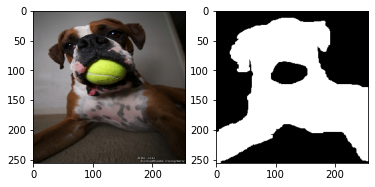

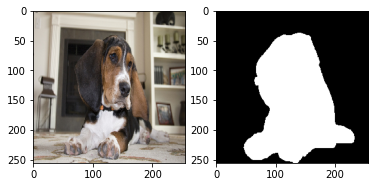

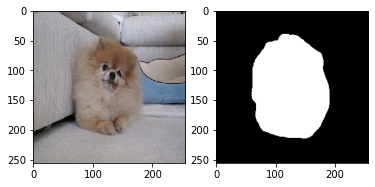

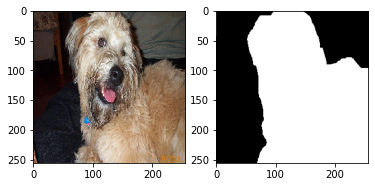

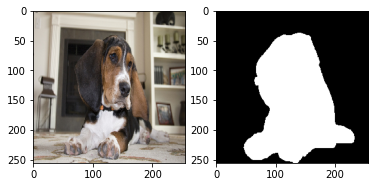

In [12]:
import matplotlib.pyplot as plt

def plotTrainData(x, y):
    for i in range(5):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
   
plotTrainData(batch_x, batch_y)

# U-Net 모델 정의

In [13]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

# 모델 컴파일과 학습

In [14]:
model = unet()

model.compile(optimizer = 'rmsprop', loss='binary_crossentropy')

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1

In [15]:
hist = model.fit_generator(
    train_data_generator,
    steps_per_epoch=train_img_generator.samples/64,
    validation_data=validation_data_generator,
    validation_steps=validation_img_generator.samples/64,
    epochs=100, 
    verbose=1)


Epoch 1/100
93/92 [==============================] - 63s 683ms/step - loss: 0.6862 - val_loss: 0.6093
Epoch 2/100
93/92 [==============================] - 49s 524ms/step - loss: 0.5557 - val_loss: 0.5606
Epoch 3/100
93/92 [==============================] - 49s 526ms/step - loss: 0.5207 - val_loss: 0.5288
Epoch 4/100
93/92 [==============================] - 49s 530ms/step - loss: 0.4939 - val_loss: 0.4845
Epoch 5/100
93/92 [==============================] - 49s 529ms/step - loss: 0.4712 - val_loss: 0.5185
Epoch 6/100
93/92 [==============================] - 49s 530ms/step - loss: 0.4399 - val_loss: 0.4600
Epoch 7/100
93/92 [==============================] - 50s 535ms/step - loss: 0.4081 - val_loss: 0.4714
Epoch 8/100
93/92 [==============================] - 49s 532ms/step - loss: 0.3774 - val_loss: 0.3386
Epoch 9/100
93/92 [==============================] - 49s 529ms/step - loss: 0.3576 - val_loss: 0.8455
Epoch 10/100
93/92 [==============================] - 49s 530ms/step - loss: 0.33

## 로스 보기

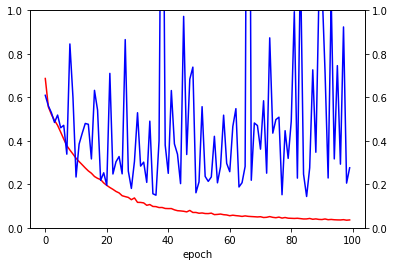

In [16]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'r')
loss_ax.plot(hist.history['val_loss'], 'b')
loss_ax.set_ylim([0.0, 1.0])


loss_ax.set_xlabel('epoch')

plt.show()

## 테스트 결과 보기

In [17]:
import matplotlib.pyplot as plt

def plotPredictions(model, x, y):

  predicted = model.predict(x)
  predicted = (predicted > 0.5).astype(np.uint8)

  for i in range(5):

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("image")
    plt.axis('off')
    plt.imshow(x[i])
    plt.subplot(1,3,2)
    plt.title("label")
    plt.axis('off')
    plt.imshow(y[i].squeeze(), 'gray')
    plt.subplot(1,3,3)
    plt.title("predicted")    
    plt.axis('off')
    plt.imshow(predicted[i].squeeze(), 'gray')
    plt.show()

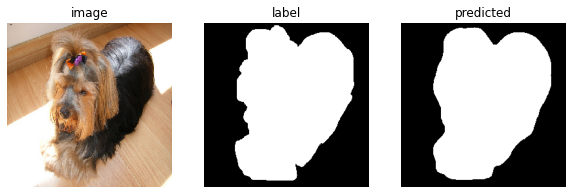

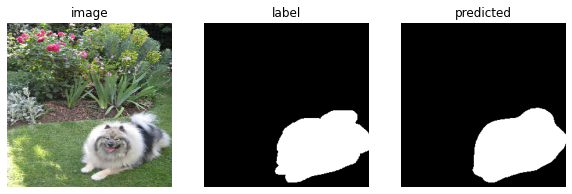

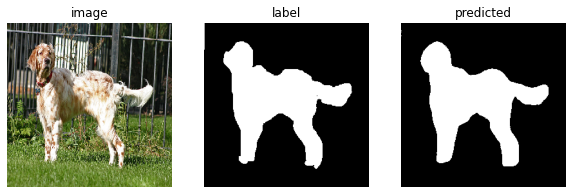

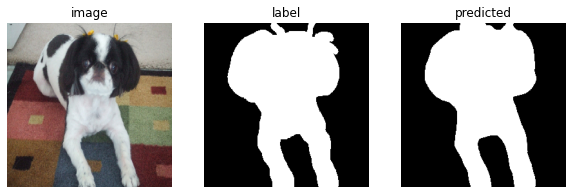

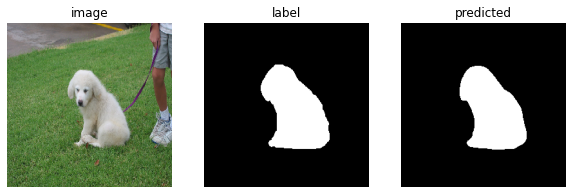

In [18]:
plotPredictions(model, batch_x, batch_y)